# This notebook is a pretraining test environment for the AMI trap classifier

## Setup

### Set the working directory appropriately

In [1]:
import os

os.chdir('..')
os.getcwd()

'/home/ucloud/EUMothModel'

### Import modules

In [27]:
import utils.config as c
import utils.mount as m
import utils.dataloader as dl

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Mount ERDA

In [3]:
m.mount()

Mounting remote directory with command: rclone mount erda:/AMI_GBIF_Pretraining_Data/root erda-home --vfs-cache-mode full --vfs-read-chunk-size 1M --vfs-cache-max-age 15m --vfs-cache-max-size 50G --max-read-ahead 1M --dir-cache-time 15m --daemon
Mounted remote directory successfully


True

### !! Unmount !!

In [ ]:
m.unmount()

## Define dataloader

In [28]:
batch_size, numworkers, pin_memory = dl.config['batch_size'], dl.config['num_workers'], dl.config['pin_memory']

image_preprocessing = transforms.Compose([
    lambda x : x.float(),
    transforms.Resize((384,384), antialias=True)
    ])

dataset = dl.PretrainingDataset(n_max=100, transform=image_preprocessing)

train_data, val_data, test_data = torch.utils.data.random_split(dataset, [int(len(dataset)*0.85), int(len(dataset)*0.05), int(len(dataset)*0.1)])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=numworkers, pin_memory=pin_memory)
val_loader   = torch.utils.data.DataLoader(  val_data, batch_size=batch_size, shuffle=True, num_workers=numworkers, pin_memory=pin_memory)
test_loader  = torch.utils.data.DataLoader( test_data, batch_size=batch_size, shuffle=True, num_workers=numworkers, pin_memory=pin_memory)

### Test the dataloader by plotting some images from different species

Train size:  3
Val size:  1
Test size:  1


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 266, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


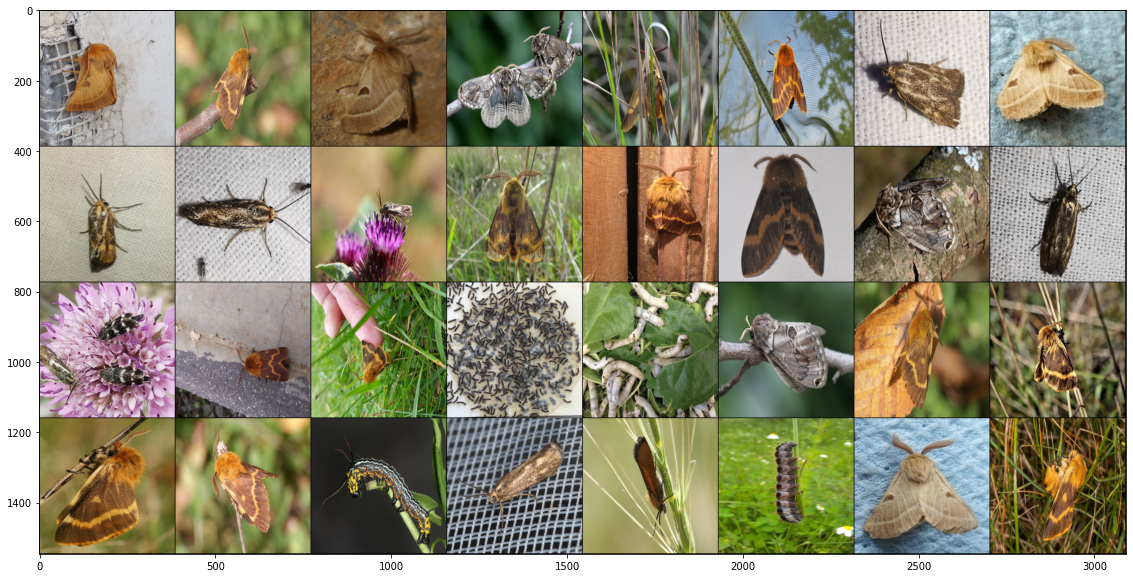

In [30]:
print("Train size: ", len(train_loader))
print("Val size: ", len(val_loader))
print("Test size: ", len(test_loader))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# show images
plt.figure(figsize=(20,10))
plt.imshow(torchvision.utils.make_grid(images, nrow = 8).permute(1,2,0) / 255)

## Define model

### Define optimizer, loss function and other hyperparameters

# Train